# Maine and Northern New England Seismic Record Plotter
*Drawing from IRIS and Raspberry Shake Seismic Repositories*

In [70]:
from obspy.clients.fdsn import Client
import math as M
from obspy import UTCDateTime
from obspy import read
from datetime import datetime, timedelta
import calendar
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
iris = Client('IRIS')
rs = Client(base_url='https://fdsnws.raspberryshakedata.com/')

In [71]:
def dt2ts(dt):
    """Converts a datetime object to UTC timestamp

    naive datetime will be considered UTC.

    """

    return calendar.timegm(dt.utctimetuple())

# function from https://docs.obspy.org/_modules/obspy/imaging/spectrogram.html#_nearest_pow_2:
def _nearest_pow_2(x):
    """
    Find power of two nearest to x

    >>> _nearest_pow_2(3)
    2.0
    >>> _nearest_pow_2(15)
    16.0

    :type x: float
    :param x: Number
    :rtype: Int
    :return: Nearest power of 2 to x
    """
    a = M.pow(2, M.ceil(np.log2(x)))
    b = M.pow(2, M.floor(np.log2(x)))
    if abs(a - x) < abs(b - x):
        return a
    else:
        return b

# traceplot/spectrogram function
def spec(data, figsize=(15,12), gain=10):
    '''
    Takes an obspy data stream
    
    Outputs a trace plot and spectrogram combined figure
    '''
    try:
        data = data.merge()[0]                      # merge all traces down to one (obspy likes to split them)
    except:
        data = data[0]                              # if that doesn't work, take the first one


    freq = data.stats.sampling_rate                 # sampling frequency in Hz of rshake (1D = 50; 3D & 4D = 100)
    start = data.stats.starttime
    end = data.stats.endtime
    seconds = end - start                           # timedelta containing number of seconds of data to display
    mplstart = dt2ts(data.times('utcdatetime')[0])
    mplend = dt2ts(data.times('utcdatetime')[-1])
    if not data.stats.location:
        data.stats.location = '--'
    name = '%s.%s.%s.%s' % (data.stats.network, data.stats.station, data.stats.location, data.stats.channel)

    npts = data.stats.npts
    wlen = freq / 100
    per_lap = 0.9
    mult = 8.0

    
    nfft = int(_nearest_pow_2(wlen * freq))
    nlap = int(nfft * per_lap)
    mult = int(_nearest_pow_2(mult))
    mult = mult * nfft

    #initialize the graph and settings
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=figsize, facecolor='white')

    ax1.set_xlim(0, npts)                           # being explicit here helps speed things up slightly
    ax1.set_ylim(min(data.data)-25, max(data.data)+25)

    if nfft > npts:
        nfft = int(_nearest_pow_2(npts / 8.0))
        nlap = int(nfft * per_lap)
    specgram = ax2.specgram(data.data, NFFT=nfft, pad_to=mult, Fs=freq, noverlap=nlap)[0] # take only the spectrogram
    specgram = np.flipud(specgram**(1/gain))        # flip and apply nth root gain
    
    # Create your x-limits. Using two of your unix timestamps you first
    # create a list of datetime.datetime objects using map.
    x_lims = list(map(datetime.utcfromtimestamp, [mplstart, mplend]))

    # You can then convert these datetime.datetime objects to the correct
    # format for matplotlib to work with.
    x_lims = mdates.date2num(x_lims)
    
    ax1.set(title='%s - %s - %s - %sHz' % (name, start, end, freq), ylabel='Counts')
    ax1.plot(data, 'k-', linewidth=0.5)

    ax2.set(xlabel='UTC Date / Time', ylabel='Frequency (Hz)')
    ax2.imshow(specgram, interpolation='nearest', extent=[x_lims[0], x_lims[1],  0, freq/2], aspect='auto')

    #ax1.xaxis_date()
    ax2.xaxis_date()
    date_format = mdates.DateFormatter('%Y.%j - %H:%M:%S')
    ax2.xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()
    ax1.tick_params(bottom=False)
    ax2.tick_params(bottom=True, top=True, length=10)
    
    plt.show()

# Event query
- [Date and Time Setup](#Event-date-and-time-setup)

### Stations
##### AM -  Raspberry Shake Community
- [AM.R4989 - Orono, ME](#AM.R4989)
- [AM.RB489 - Pigeon Hill, ME](#AM.RB489)
- [AM.R35E7 - West Poland, ME](#AM.R35E7)
- [AM.R94FB - Brunswick, ME](#AM.R94FB)
- [AM.R8F50 - Windsor, VT](#AM.R8F50)
- [AM.RCB43 - Williamstown, MA](#AM.RCB43)

##### US - USArray
- [US.PKME - Peaks-Kenny, ME](#US.PKME)
- [US.LBNH - Lisbon, NH](#US.LBNH)

##### NE - New England Seismic Network
- [NE.ORNO aka AM.R6F62 - Orono, ME](#NE.ORNO)
- [NE.EMMW - Machias, ME](#NE.EMMW)
- [NE.PQI - Presque Isle, ME](#NE.PQI)
- [NE.WVL - Waterville, ME](#NE.WVL)
- [NE.HNH - Hanover, NH](#NE.HNH)
- [NE.TRY - Troy, NY](#NE.TRY)

##### N4 - Central and Eastern US Network
- [N4.G65A - Princeton, ME](#N4.G65A)
- [N4.F64A - Sherman, ME](#N4.F64A)
- [N4.F63A - Browneville, ME](#N4.F63A)
- [N4.I63A - Otisfield, ME](#N4.I63A)
- [N4.I62A - Tamworth, NH](#N4.I62A)
- [N4.K62A - Royalston, MA](#N4.K62A)

##### LD - Lamont Doherty Cooperative Network
- [LD.UNH - Durham, NH](#LD.UNH)

### Event date and time setup

In [115]:
#start_1 = "2018-09-21T13:54:28.360000Z"  # M1.7 Nashua Area NH
#end_1 = "2018-09-21T13:56:00.360000Z"    # M1.7 Nashua Area NH
start_1 = "2018-09-22T06:35:50.00"       # M1.8 White River Jct Area VT
end_1 = "2018-09-22T06:38:00.00"         # M1.8 White River Jct Area VT
starttime = UTCDateTime(start_1)
endtime = UTCDateTime(end_1)

print('Year:       %s' % starttime.strftime('%Y'))
print('Julian Day: %s' % starttime.strftime('%j'))

freqmin = 0.5         # highpass frequency (filter below)

Year:       2018
Julian Day: 265


### AM.R4989
#### Raspberry Shake R4989 - Orono, ME ([back](#Event-query))

/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (50.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


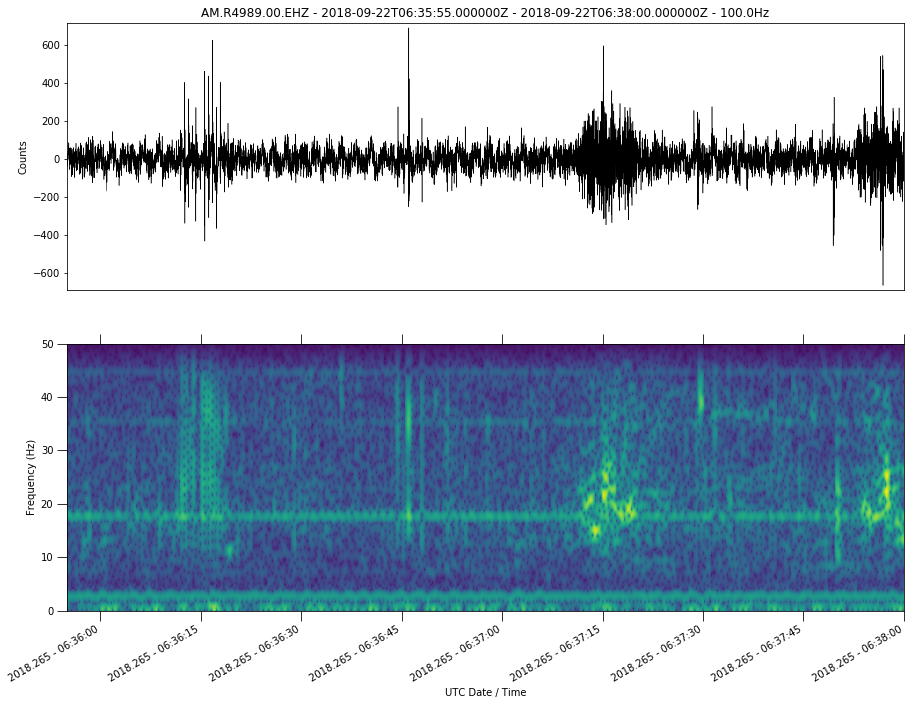

In [116]:
q1 = rs.get_waveforms('AM', 'R4989', '00', 'EHZ', starttime, endtime)
f = q1.merge()
f = f.filter('bandpass', freqmin=freqmin, freqmax=f[0].stats.sampling_rate/2)
f = f.slice(starttime+timedelta(seconds=5), endtime)
spec(f, gain=6)

### AM.RB489
#### Raspberry Shake RB489 - Pigeon Hill, ME ([back](#Event-query))

/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (50.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


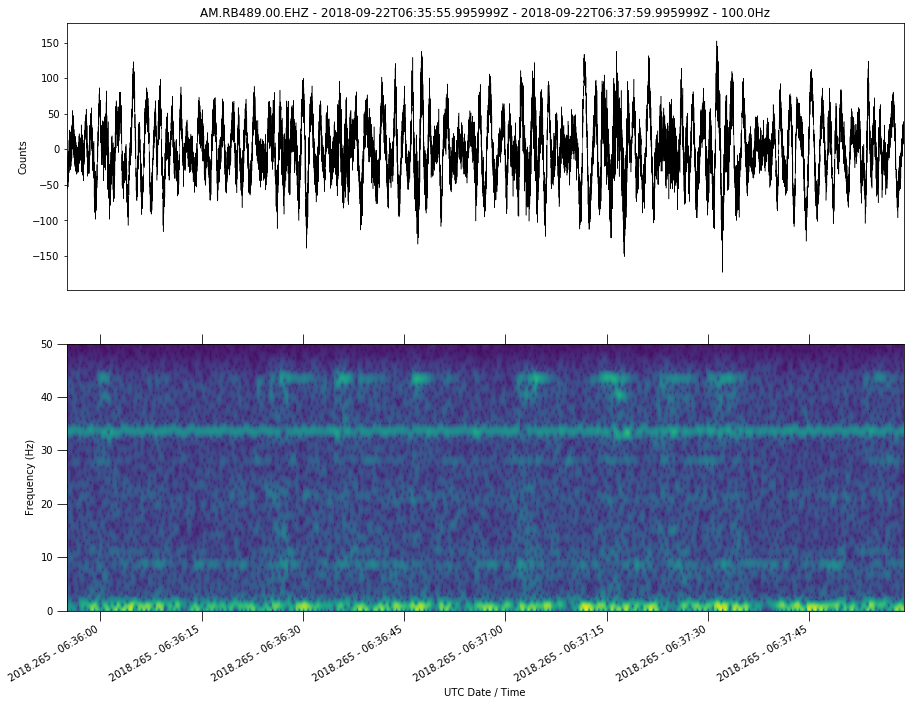

In [117]:
q2 = rs.get_waveforms('AM', 'RB489', '00', 'EHZ', starttime, endtime)
f = q2.merge()
f = f.filter('bandpass', freqmin=freqmin, freqmax=f[0].stats.sampling_rate/2)
f = f.slice(starttime+timedelta(seconds=6), endtime)
spec(f, gain=6)

### AM.R35E7
#### Raspberry Shake R35E7 - West Poland, ME ([back](#Event-query))

/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (25.0) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


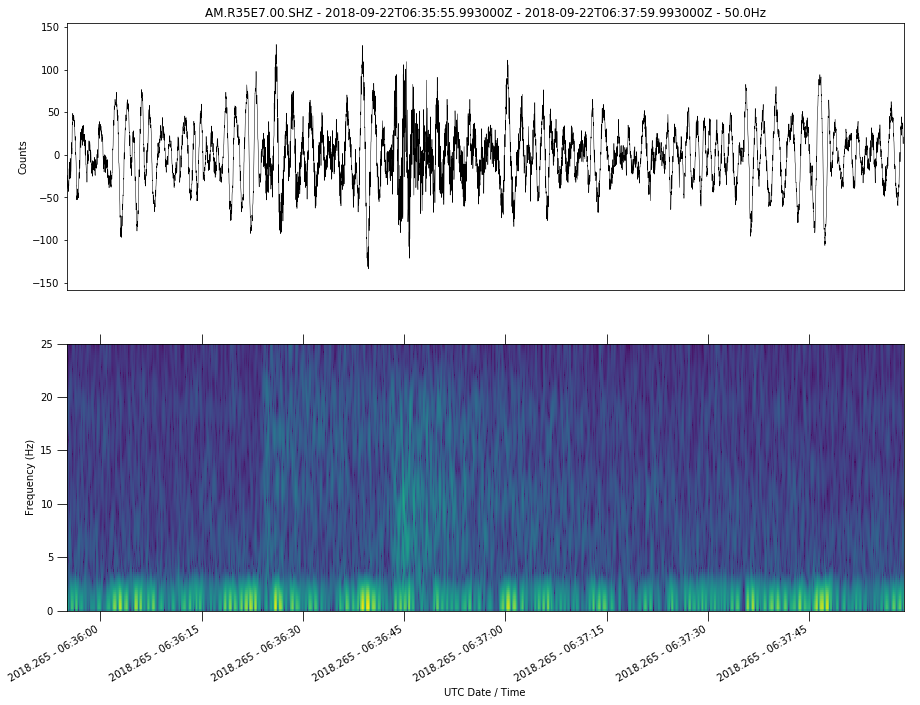

In [118]:
q2 = rs.get_waveforms('AM', 'R35E7', '00', 'SHZ', starttime, endtime)
f = q2.merge()
f = f.filter('bandpass', freqmin=freqmin, freqmax=f[0].stats.sampling_rate/2)
f = f.slice(starttime+timedelta(seconds=6), endtime)
spec(f, gain=6)

### AM.R94FB
#### Raspberry Shake R94FB - Brunswick, ME ([back](#Event-query))

In [119]:
q2 = rs.get_waveforms('AM', 'R94FB', '00', 'EHZ', starttime, endtime)
f = q2.merge()
f = f.filter('bandpass', freqmin=freqmin, freqmax=f[0].stats.sampling_rate/2)
f = f.slice(starttime+timedelta(seconds=6), endtime)
spec(f, gain=6)

FDSNNoDataException: No data available for request.
Detailed response of server:



### AM.R8F50
#### Raspberry Shake R8F50 - Windsor, VT ([back](#Event-query))

/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (25.0) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


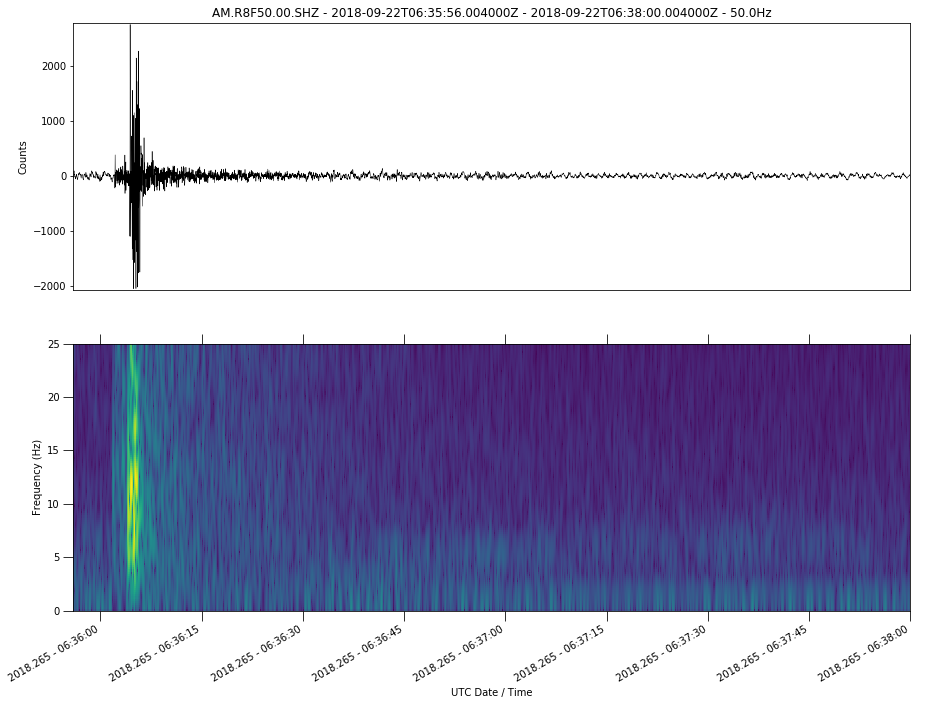

In [120]:
q2 = rs.get_waveforms('AM', 'R8F50', '00', 'SHZ', starttime, endtime)
f = q2.merge()
f = f.filter('bandpass', freqmin=freqmin, freqmax=f[0].stats.sampling_rate/2)
f = f.slice(starttime+timedelta(seconds=6), endtime)
spec(f, gain=6)

### AM.RCB43
#### Raspberry Shake RCB43 - Williamstown, MA ([back](#Event-query))

/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (25.0) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


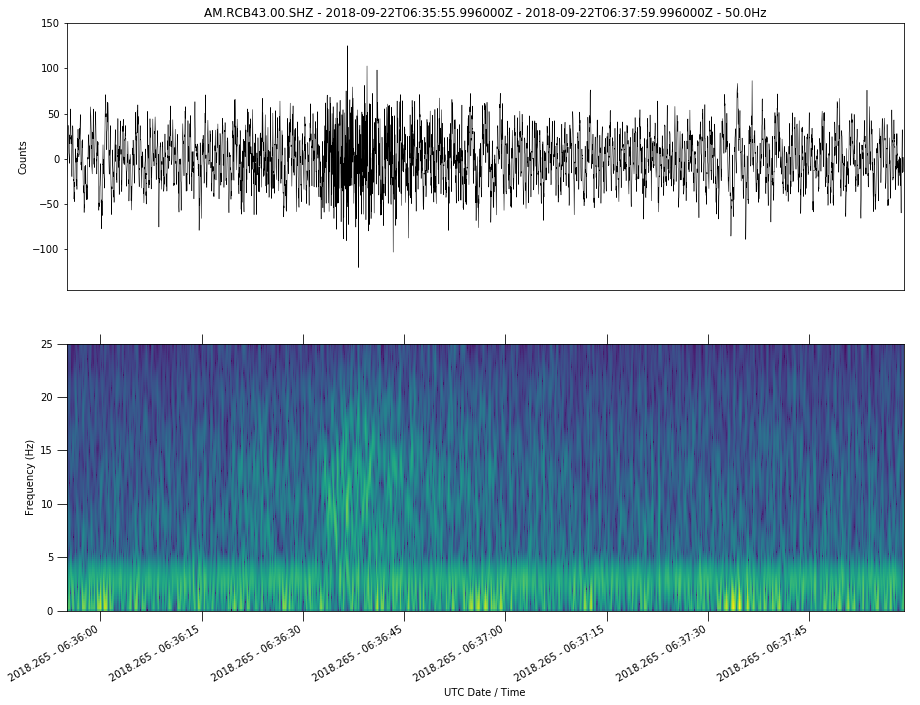

In [121]:
q2 = rs.get_waveforms('AM', 'RCB43', '00', 'SHZ', starttime, endtime)
f = q2.merge()
f = f.filter('bandpass', freqmin=freqmin, freqmax=f[0].stats.sampling_rate/2)
f = f.slice(starttime+timedelta(seconds=6), endtime)
spec(f, gain=6)

### US.PKME
#### USArray station US.PKME, Peaks-Kenny, ME ([back](#Event-query))

/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (20.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


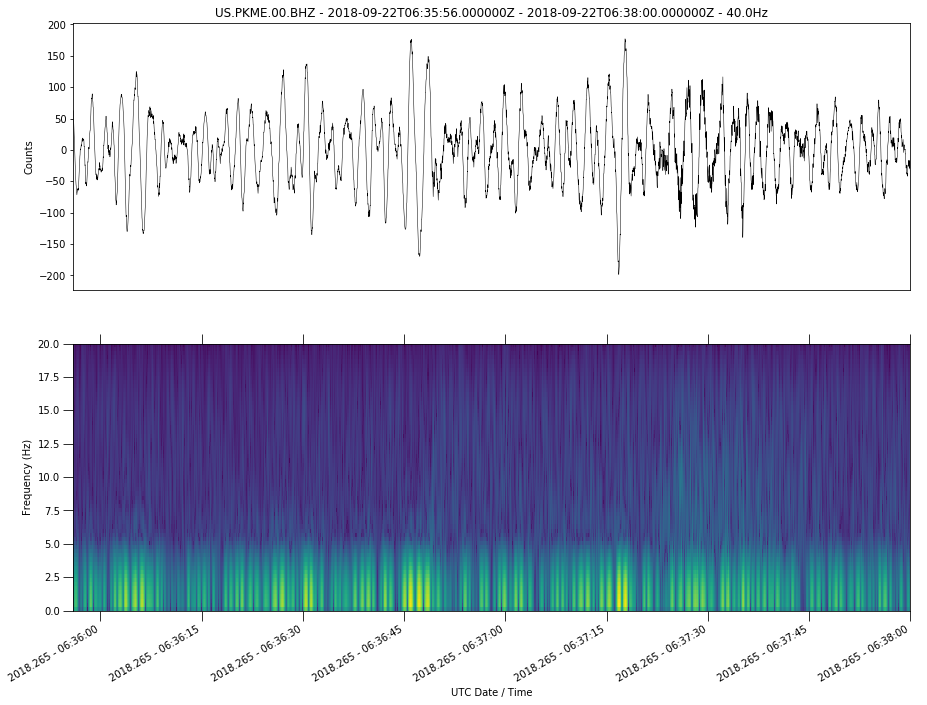

In [122]:
q3 = iris.get_waveforms('US', 'PKME', '00', 'BHZ', starttime, endtime)
f = q3.merge()
f = f.filter('bandpass', freqmin=freqmin, freqmax=f[0].stats.sampling_rate/2)
f = f.slice(starttime+timedelta(seconds=6), endtime)
spec(f, gain=6)

### US.LBNH
#### USArray station US.LBNH, Lisbon, NH ([back](#Event-query))

/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (20.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


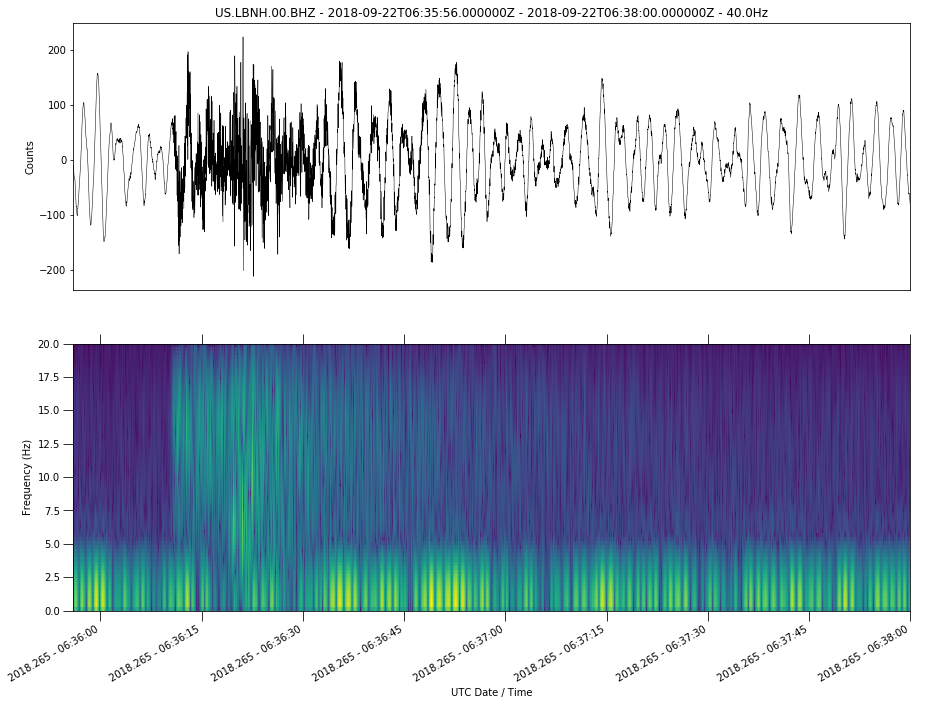

In [123]:
q3 = iris.get_waveforms('US', 'LBNH', '00', 'BHZ', starttime, endtime)
f = q3.merge()
f = f.filter('bandpass', freqmin=freqmin, freqmax=f[0].stats.sampling_rate/2)
f = f.slice(starttime+timedelta(seconds=6), endtime)
spec(f, gain=6)

### NE.PQI
#### NESN Station PQI - Presque Isle, ME ([back](#Event-query))

/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (50.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


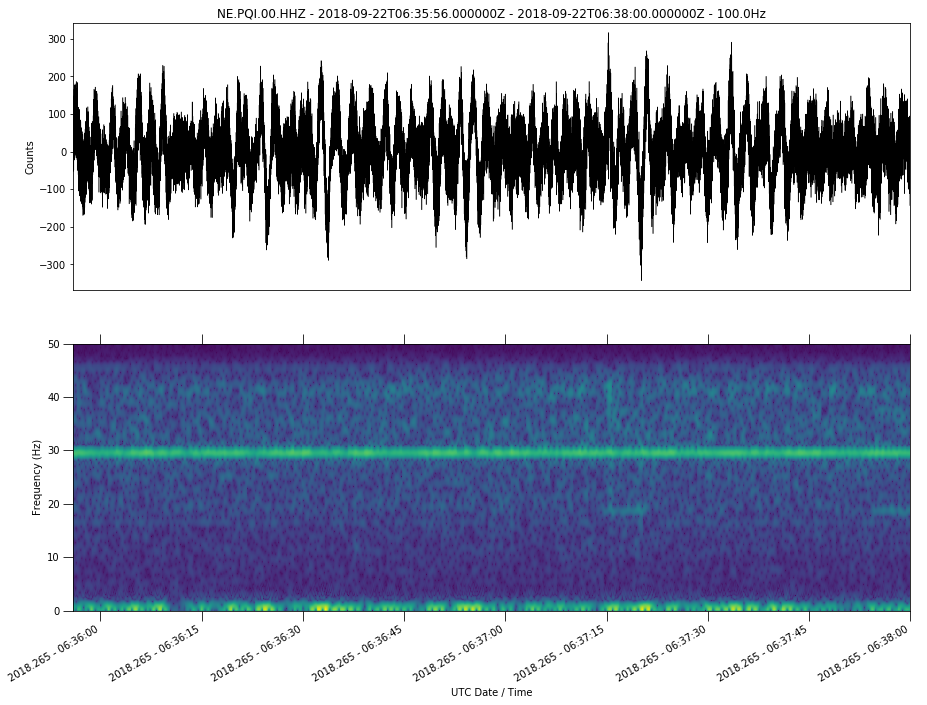

In [124]:
q3 = iris.get_waveforms('NE', 'PQI', '00', 'HHZ', starttime, endtime)
f = q3.merge()
f = f.filter('bandpass', freqmin=freqmin, freqmax=f[0].stats.sampling_rate/2)
f = f.slice(starttime+timedelta(seconds=6), endtime)
spec(f, gain=6)

### NE.ORNO
#### NESN Station NE.ORNO -  University of Maine seismic vault, Orono, ME ([back](#Event-query))
##### AKA Raspberry Jam R6F62

/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (50.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


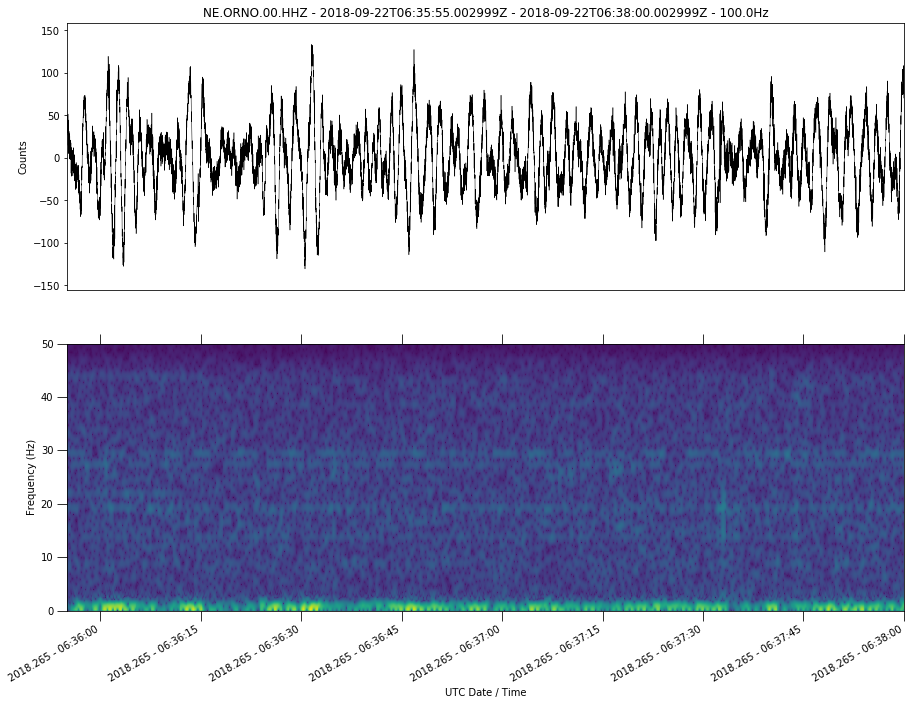

In [125]:
q3 = read('../../seismic/AM.R6F62.00.EHZ.D.%s' % starttime.strftime('%Y.%j'))
q3 = q3.slice(starttime, endtime)
f = q3.merge()
f = f.filter('bandpass', freqmin=freqmin, freqmax=f[0].stats.sampling_rate/2)
f = f.slice(starttime+timedelta(seconds=5), endtime)
f[0].stats.station = 'ORNO'
f[0].stats.network = 'NE'
f[0].stats.channel = 'HHZ'
spec(f, gain=6)

### NE.EMMW
#### NESN Station EMMW - Machias, ME ([back](#Event-query))

/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (50.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


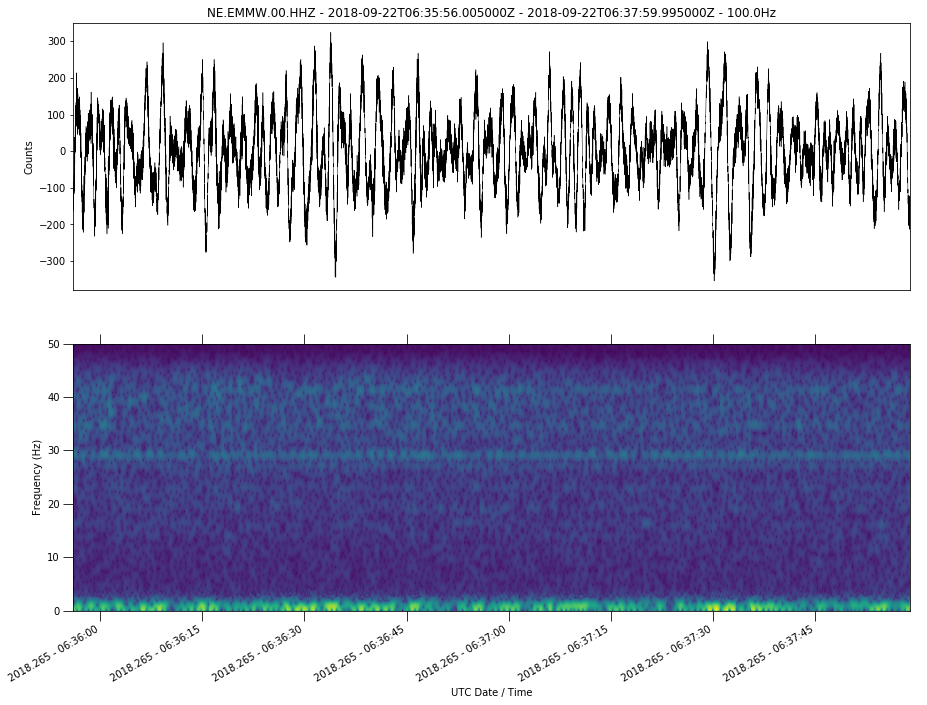

In [126]:
q3 = iris.get_waveforms('NE', 'EMMW', '00', 'HHZ', starttime, endtime)
f = q3.merge()
f = f.filter('bandpass', freqmin=freqmin, freqmax=f[0].stats.sampling_rate/2)
f = f.slice(starttime+timedelta(seconds=6), endtime)
spec(f, gain=6)

### NE.WVL
#### NESN Station WVL - Colby College, Waterville, ME ([back](#Event-query))

/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (50.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


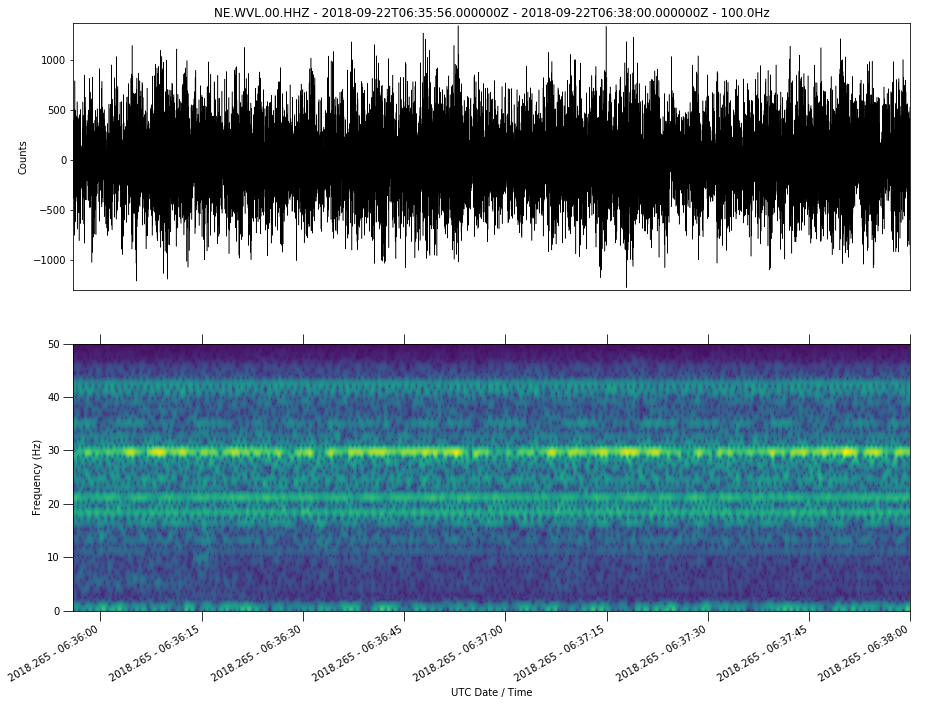

In [127]:
q3 = iris.get_waveforms('NE', 'WVL', '00', 'HHZ', starttime, endtime)
f = q3.merge()
f = f.filter('bandpass', freqmin=freqmin, freqmax=f[0].stats.sampling_rate/2)
f = f.slice(starttime+timedelta(seconds=6), endtime)
spec(f, gain=6)

### NE.HNH
#### NESN Station HNH - Dartmouth College, Hanover, NH ([back](#Event-query))

/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (50.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


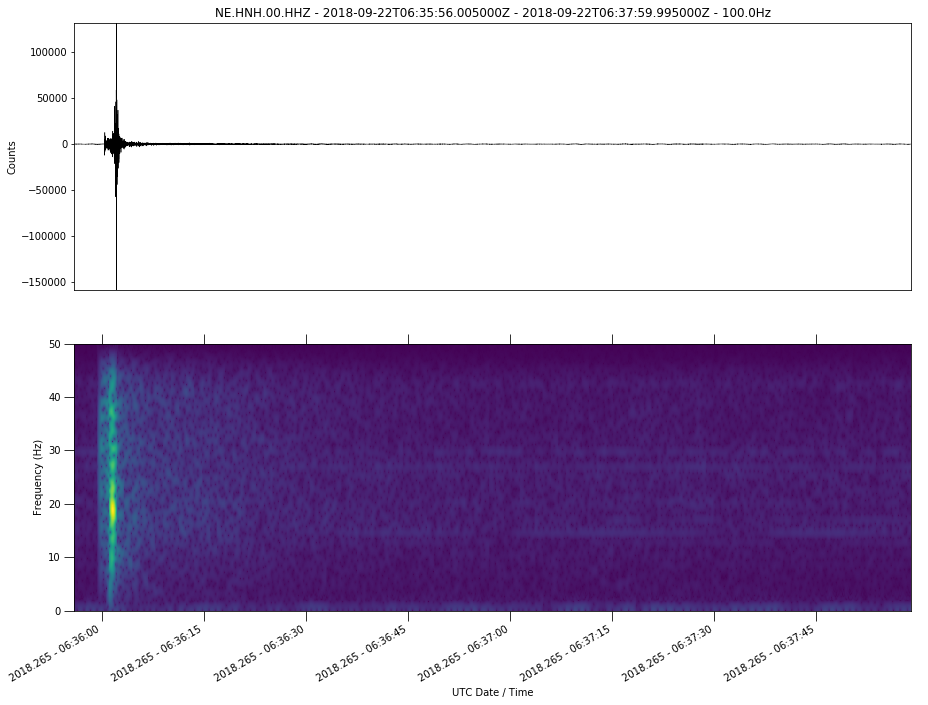

In [141]:
q3 = iris.get_waveforms('NE', 'HNH', '00', 'HHZ', starttime, endtime)
f = q3.merge()
f = f.filter('bandpass', freqmin=freqmin, freqmax=f[0].stats.sampling_rate/2)
f = f.slice(starttime+timedelta(seconds=6), endtime)
spec(f, gain=6)

### NE.TRY
#### NESN Station WVL - Renssellaer Polytechnic Institute, Troy, NY ([back](#Event-query))

/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (50.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


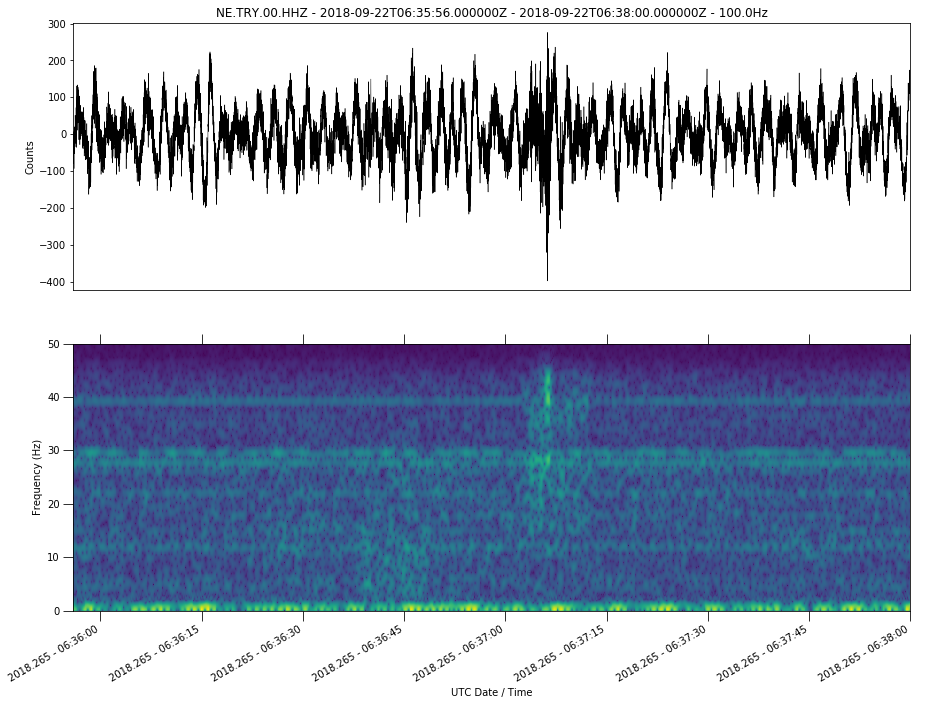

In [129]:
q3 = iris.get_waveforms('NE', 'TRY', '00', 'HHZ', starttime, endtime)
f = q3.merge()
f = f.filter('bandpass', freqmin=freqmin, freqmax=f[0].stats.sampling_rate/2)
f = f.slice(starttime+timedelta(seconds=6), endtime)
spec(f, gain=6)

### N4.G65A
#### Central and Eastern US Station G65A - Princeton, ME ([back](#Event-query))

/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (50.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


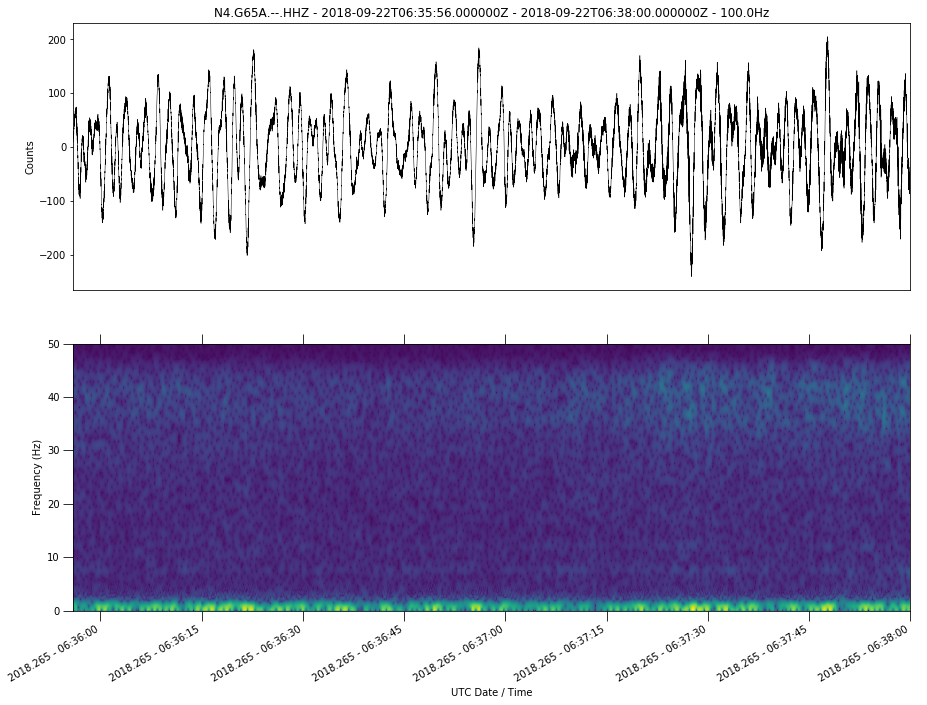

In [130]:
q3 = iris.get_waveforms('N4', 'G65A', '--', 'HHZ', starttime, endtime)
f = q3.merge()
f = f.filter('bandpass', freqmin=freqmin, freqmax=f[0].stats.sampling_rate/2)
f = f.slice(starttime+timedelta(seconds=6), endtime)
spec(f, gain=6)

### N4.F64A
#### Central and Eastern US Station F64A - Sherman, ME ([back](#Event-query))

/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (50.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


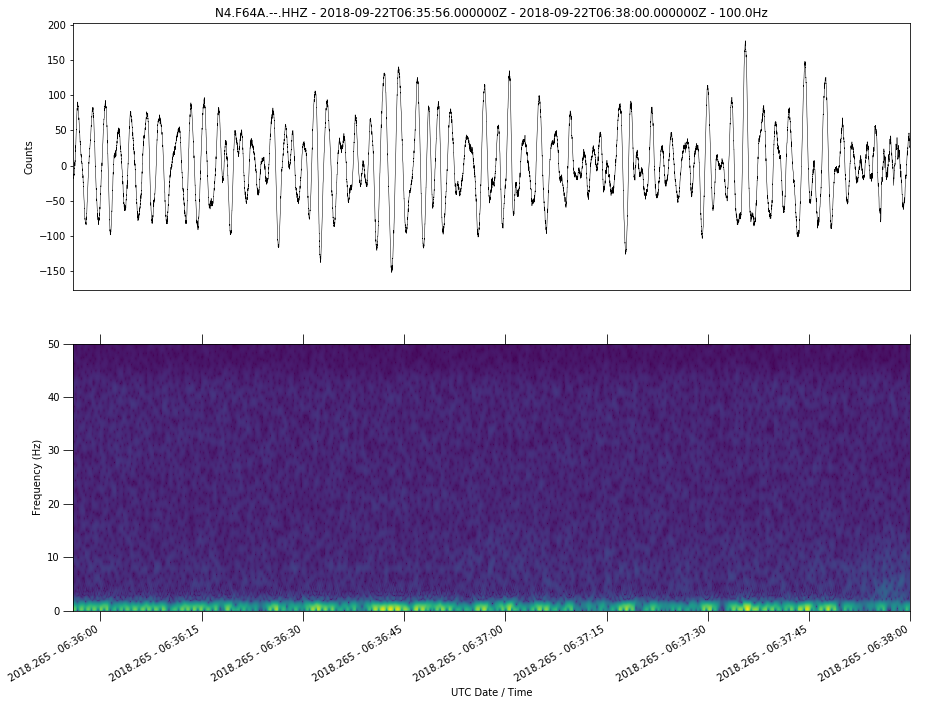

In [131]:
q3 = iris.get_waveforms('N4', 'F64A', '--', 'HHZ', starttime, endtime)
f = q3.merge()
f = f.filter('bandpass', freqmin=freqmin, freqmax=f[0].stats.sampling_rate/2)
f = f.slice(starttime+timedelta(seconds=6), endtime)
spec(f, gain=6)

### N4.F63A
#### Central and Eastern US Station F63A - Nahmakanta Public Land, Browneville, ME ([back](#Event-query))

In [132]:
q3 = iris.get_waveforms('N4', 'F63A', '--', 'HHZ', starttime, endtime)
f = q3.merge()
f = f.filter('bandpass', freqmin=freqmin, freqmax=f[0].stats.sampling_rate/2)
f = f.slice(starttime+timedelta(seconds=6), endtime)
spec(f, gain=6)

FDSNNoDataException: No data available for request.
Detailed response of server:



### N4.I63A
#### Central and Eastern US Station I63A - Otisfield, ME ([back](#Event-query))

/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (50.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


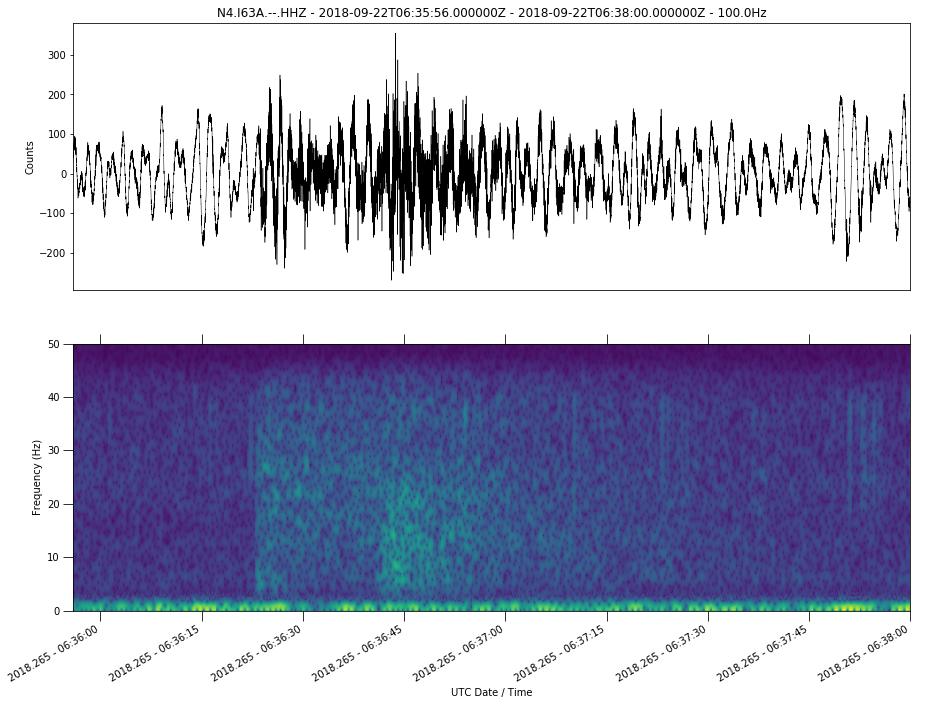

In [133]:
q3 = iris.get_waveforms('N4', 'I63A', '--', 'HHZ', starttime, endtime)
f = q3.merge()
f = f.filter('bandpass', freqmin=freqmin, freqmax=f[0].stats.sampling_rate/2)
f = f.slice(starttime+timedelta(seconds=6), endtime)
spec(f, gain=6)

### N4.I62A
#### Central and Eastern US Station I62A - Tamworth, NH ([back](#Event-query))

/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (50.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


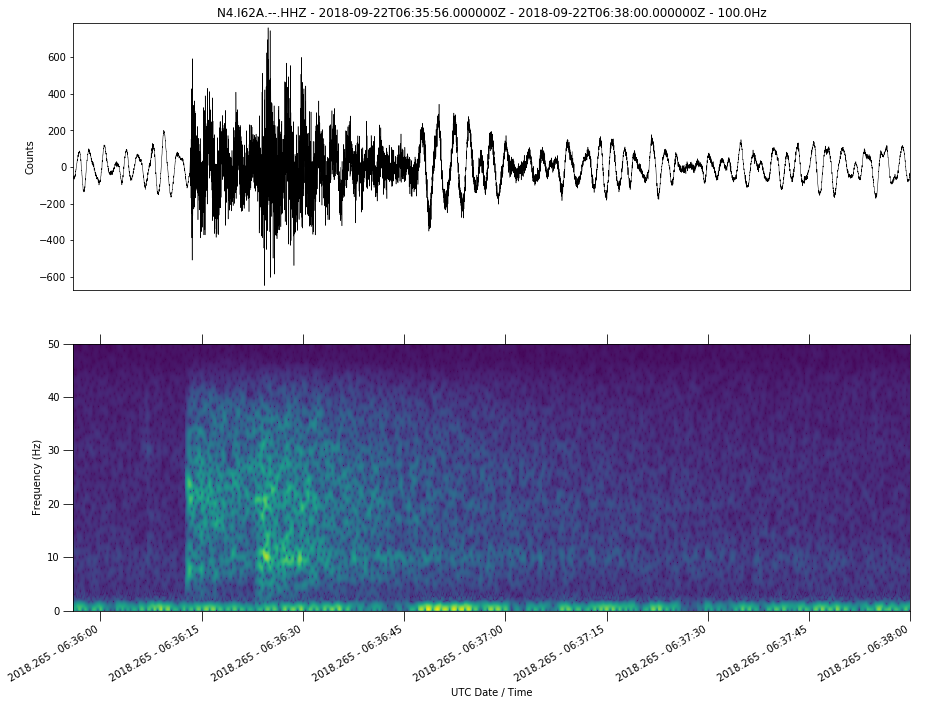

In [134]:
q3 = iris.get_waveforms('N4', 'I62A', '--', 'HHZ', starttime, endtime)
f = q3.merge()
f = f.filter('bandpass', freqmin=freqmin, freqmax=f[0].stats.sampling_rate/2)
f = f.slice(starttime+timedelta(seconds=6), endtime)
spec(f, gain=6)

### N4.K62A
#### Central and Eastern US Station K62A - Royalston, MA ([back](#Event-query))

/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (50.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


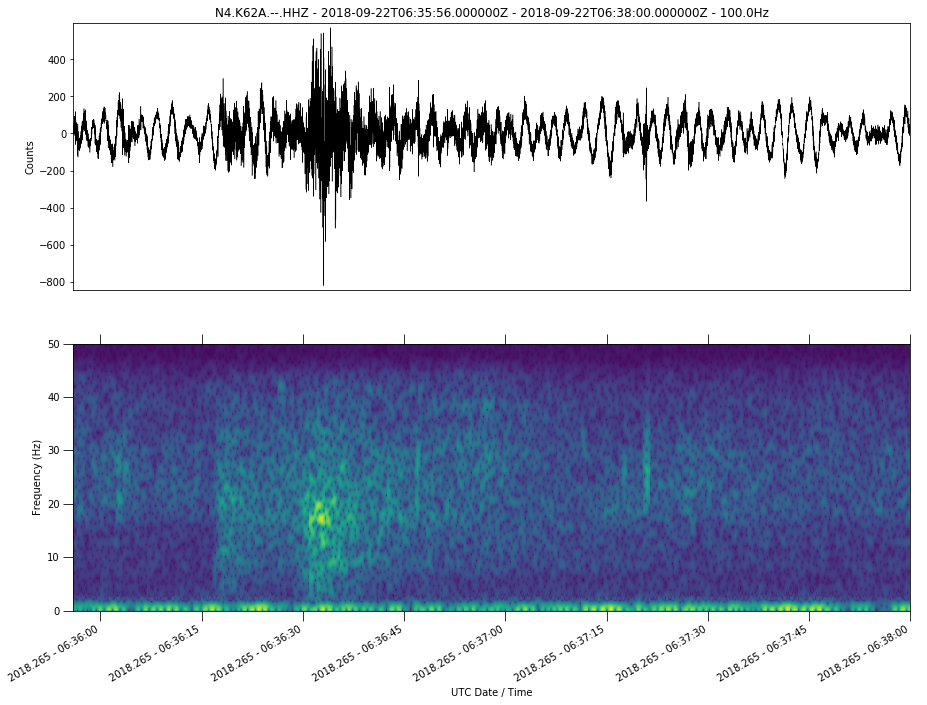

In [135]:
q3 = iris.get_waveforms('N4', 'K62A', '--', 'HHZ', starttime, endtime)
f = q3.merge()
f = f.filter('bandpass', freqmin=freqmin, freqmax=f[0].stats.sampling_rate/2)
f = f.slice(starttime+timedelta(seconds=6), endtime)
spec(f, gain=6)

### LD.UNH
#### Lamont Doherty Cooperative Station UNH - Durham, NH ([back](#Event-query))

/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (50.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/iannesbitt/anaconda3/envs/obspy3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


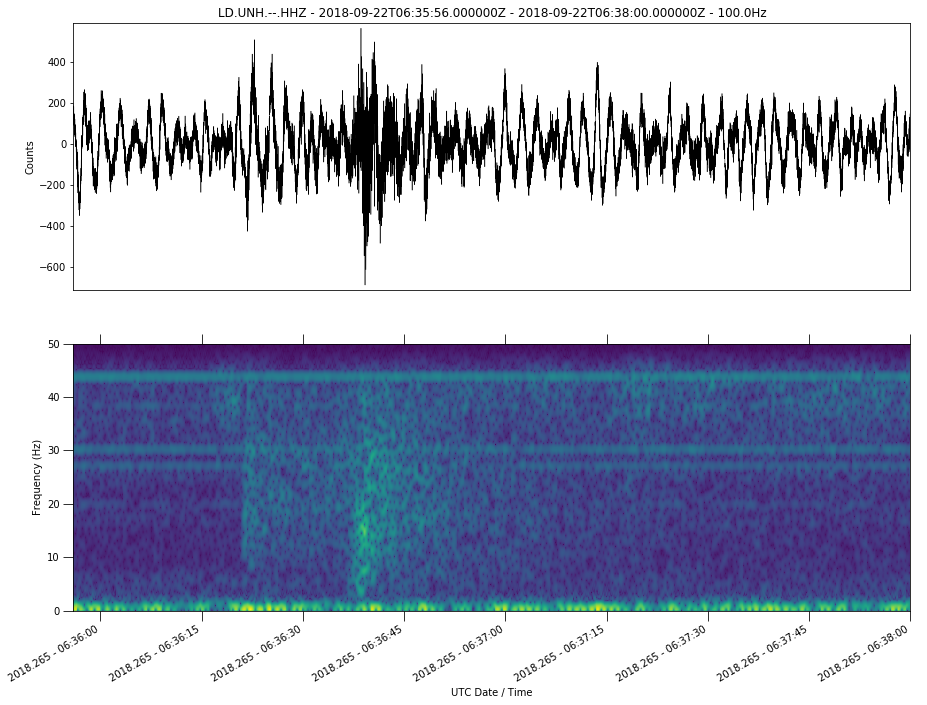

In [142]:
q3 = iris.get_waveforms('LD', 'UNH', '--', 'HHZ', starttime, endtime)
f = q3.merge()
f = f.filter('bandpass', freqmin=freqmin, freqmax=f[0].stats.sampling_rate/2)
f = f.slice(starttime+timedelta(seconds=6), endtime)
spec(f, gain=6)